In [1]:
#autoencoder , 정답을 알려주지않으면서 학습시키는 것
#얼마나 잘 복원하는지에 대한 복원오차, 정보손실값을 이용하여 복원하는데 목표가 있음.
#작은차원에 압축된 표현을 잠재변수 latent variable이라고 하고, 간단하게 z라고 부름
#주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 사용, 비정상 거래 검출, 데이터 시각화와 복원, 의미 추출, 이미지 검색 등


In [3]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms,datasets

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [5]:
#hyper parameter 
EPOCH = 10 
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('using_device',DEVICE)

using_device cpu


In [6]:
#Fmnist dataset loading
trainset = datasets.FashionMNIST(
    root= './.data/',
    train = True,
    download= True,
    transform= transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [7]:
#autoencoder module define
#오토인코더에는 encoder부분과 decoder부분이 있음 이를 nn.Sequential를 이용하여 묶어줄 것임
#nn.Sequential는 여러 모듈을 하나로 묶을 수 있음, 코드를 간결하게 만들수있고 계층과 활성화함수를 정의해주면 순서대로 값을 전달해 처리함
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),#마지막 3차원에서 시각화할 수 있도록 feature를 3개만 남김
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid(),
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    

In [8]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = 0.005)
criterion = nn.MSELoss()

In [11]:
#원본 이미지 시각화하기
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255. # 255로 나누는 이유는 픽셀의 색상값이 0-255이고 0과 1 사이의 값으로 만들어야지
#모델이 인식하기 때문이다.


In [12]:
def train(autoencoder,train_loader):
    autoencoder.train()
    for step, (x,label) in enumerate(train_loader):
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded,y) # decoded 된 데이터와 원본 이미지 데이터와 비교
        #MSE loss 차이의 제곱의 평균 !
        optimizer.zero_grad()#함수에 있을수도 있는 grad초기화
        loss.backward()#backward 로 기울기를 구함
        optimizer.step()#step으로 최적화 진행

epoch1


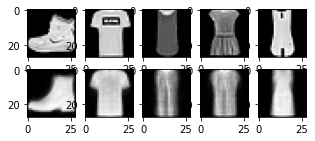

epoch2


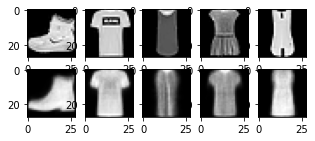

epoch3


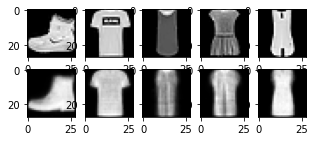

epoch4


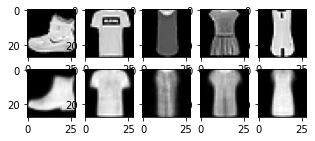

epoch5


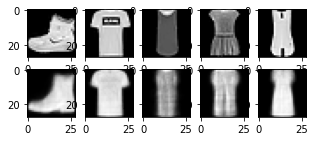

epoch6


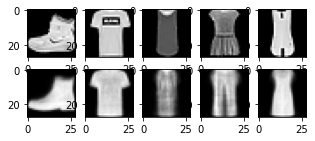

epoch7


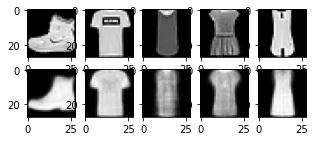

epoch8


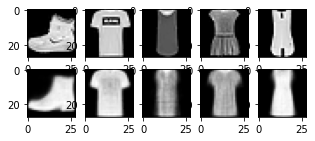

epoch9


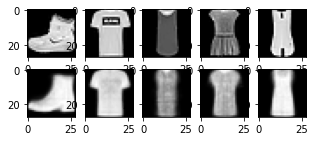

epoch10


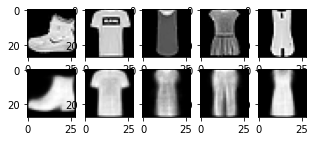

In [14]:
for epoch in range(1,EPOCH+1):
    train(autoencoder,train_loader)
    test_x = view_data.to(DEVICE) #디코더에서 나온 이미지를 시각화하기
    _,decoded_data = autoencoder(test_x)
    #원본과 디코딩 결과를 비교해보기
    f,a = plt.subplots(2,5,figsize=(5,2))#2줄 5칸 으로 한줄엔 원본, 한줄엔 복원된 사진을 넣을 것임
    print('epoch{}'.format(epoch))
    #맷플롯립은 파이토치 텐서를 지원하지 않으므로 넘파이 행렬로 변형해줘야함
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img,cmap='gray')
    #cuda를 사용한다면 모델의 출력값이 아직 gpu에 남아있으므로 to('cpu')를 통하여 일반 메모리로 가져온 후 numpy함수를 사용해 넘파이 행렬로 변환해줘야함
    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28))
        a[1][i].imshow(img,cmap='gray')
    plt.show()

In [15]:
#학습이 완료된 오토인코더에서 나온 잠재변수들이 3차원에서 어떻게 분포되는지 알아보자
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data,_ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')

In [16]:
#각 잠재 변수에 레이블을 붙이고자 다음 딕셔너리 준비함 
CLASSES = {
    0: 'Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

/var/folders/8l/j5s453353hq1w6y418hl73kr0000gn/T/ipykernel_6626/3657046387.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


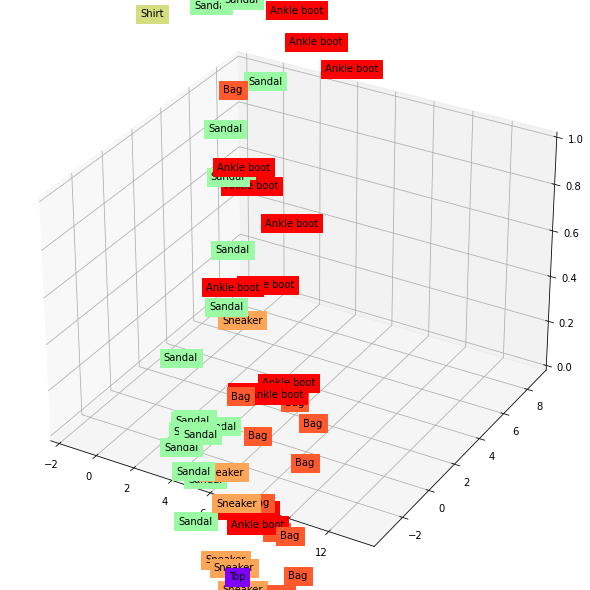

In [20]:
#이번엔 Axes3D 함수로 3차원의 액자를 만든 후 잠재변수의 각 차원 xyz를 따로 추출하여 numpy함수로 변환함. 그리고 200개의 이미지에 해당하는 레이블도
#numpy행렬로 변환
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.targets[:200].numpy()
#zip함수는 같은 길이의 행렬들을 모아 순서대로 묶어줌
#묶어서 xyz의 위치를 지정해줌

for x,y,z,s in zip(X,Y,Z,labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name,backgroundcolor = color)
#x,y,z의 최솟값과 최댓값을 지정해줌
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_xlim(Z.min(),Z.max())
plt.show()